In [1]:
### Cross-context decoding (task --> naturalistic behaivor)
### S+ and S-

# Cell 1: Imports and setup

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm, metrics
import glob
from scipy.ndimage import gaussian_filter1d
from pathlib import Path

import helperFunc

# Base paths (relative to current working directory)
cwd = Path.cwd()
masterlistpath = cwd / "experiment1_taskfreelymovingspecificity.csv"
folderpath = cwd / "data_timewarped"
folderpath_prelearning = folderpath / "prelearning"
folderpath_postlearning = folderpath / "postlearning"
savepath = cwd / "Figure4FG"
helperFunc.makefolder(savepath)

savename = "experiment1"
areas = [["LA"], ['BLA'], ['PIR']]  # extend to other areas if needed
iterationstorun = 100

roc = True
rocdata = 0        # 0 = sensory, 1 = action, 2 = outcome
freelymoving_ts = 115

parameters = [
    ['iterationstorun', iterationstorun],
    ['rocdata', rocdata],
    ['masterlistpath', str(masterlistpath)],
    ['taskfolder', str(folderpath)]
]

assignrewarded, assignunrewarded = 0, 1




In [2]:
# Cell 2: Define functions

def trainSVM_4animals(frvalues, labels, frfreelymoving, freelymovingtrialorder, roc=False):
    """Train SVM on task data and test on freely-moving data."""
    svc = svm.SVC(kernel='linear')

    if roc:
        Xstd = frvalues
        freelymovingstd = frfreelymoving
    else:
        scaler = StandardScaler().fit(frvalues)
        Xstd = scaler.transform(frvalues)
        freelymovingstd = scaler.transform(frfreelymoving)

    svc.fit(Xstd, labels)
    ypred = np.zeros(frfreelymoving.shape[0])
    for i in range(frfreelymoving.shape[0]):
        ypred[i] = svc.predict(freelymovingstd[i].reshape(1, -1))[0]

    accuracy = metrics.accuracy_score(freelymovingtrialorder, ypred)
    return ypred, accuracy


def calculatefreelymovingmatrix_trials(neuronlist, cwd):
    """Build ROC values for freely moving data."""
    freelymovingfrmatrix = np.full((2, 115, len(neuronlist)), np.nan)

    for n, neuron in enumerate(neuronlist):
        rat, date, area, unitid = neuron[0], neuron[1], neuron[2], neuron[4]

        eventpath = cwd / 'NaturalisticSocial' / f"{rat}_{date}" / "Events.csv"
        events = np.loadtxt(eventpath, delimiter=',', dtype=str)
        starttime = events[:2, 1].astype(float)

        neuronpath = cwd / 'NaturalisticSocial' / f"{rat}_{date}" / "Neurons" / f"{unitid}.npy"
        spikes = np.load(neuronpath) / 1000

        for s, time in enumerate(starttime):
            basestart = events[s, 1].astype(float) - 60
            fr = helperFunc.extractspkfr(spikes, 1, basestart, basestart + 60)
            fr = np.append(fr, helperFunc.extractspkfr(spikes, 1, time, time + 120))
            fr = gaussian_filter1d(fr, 1)
            basefr = fr[:50]

            for x in range(115):
                freelymovingfrmatrix[s, x, n] = helperFunc.calcROC(basefr, fr[x:x + 5])[0]

    freelymovingfrmatrix[np.isnan(freelymovingfrmatrix)] = 0.5
    return freelymovingfrmatrix


def calculate4animalneuronmatrix(folderpath, neuronlist,
                                 assignrewarded, assignunrewarded, roc=False):
    """Build FR or ROC matrices for task data."""
    size = 3 if roc else 40
    frmatrix_rewarded = np.full((100, size, len(neuronlist)), np.nan)
    frmatrix_unrewarded = np.full((100, size, len(neuronlist)), np.nan)
    labelmatrix_rewarded = np.full((200, neuronlist.shape[0]), np.nan)
    labelmatrix_unrewarded = np.full((200, neuronlist.shape[0]), np.nan)

    for n, neuron in enumerate(neuronlist):
        rat, date, area, unitid = neuron[0], neuron[1], neuron[2], neuron[3]
        pathname = f"{rat}_{date}_*_{unitid}"

        rewardpath = glob.glob(str(folderpath / f"{pathname}_rewarded.npy"))[0]
        unrewardpath = glob.glob(str(folderpath / f"{pathname}_unrewarded.npy"))[0]

        if roc:
            frmatrix_rewarded, labelmatrix_rewarded = loadandcalcroc(
                rewardpath, frmatrix_rewarded, labelmatrix_rewarded, n, assignrewarded
            )
            frmatrix_unrewarded, labelmatrix_unrewarded = loadandcalcroc(
                unrewardpath, frmatrix_unrewarded, labelmatrix_unrewarded, n, assignunrewarded
            )
        else:
            reward = np.load(rewardpath)
            unreward = np.load(unrewardpath)
            frmatrix_rewarded[:reward.shape[0], :, n] = reward * 10
            frmatrix_unrewarded[:unreward.shape[0], :, n] = unreward * 10
            labelmatrix_rewarded[:reward.shape[0], n] = np.full(reward.shape[0], assignrewarded)
            labelmatrix_unrewarded[:unreward.shape[0], n] = np.full(unreward.shape[0], assignunrewarded)

    if roc:
        frmatrix_rewarded[np.isnan(frmatrix_rewarded)] = 0.5
        frmatrix_unrewarded[np.isnan(frmatrix_unrewarded)] = 0.5

    return frmatrix_rewarded, frmatrix_unrewarded, labelmatrix_rewarded, labelmatrix_unrewarded


def loadandcalcroc(path, savematrix, labelmatrix, n, fillvalue):
    """Compute ROC values for sensory, action, outcome epochs."""
    data = np.load(path)
    baseline, sensory, action, outcome = data[:, 0:10], data[:, 13:17], data[:, 20:30], data[:, 30:40]

    for x in range(baseline.shape[0]):
        savematrix[x, 0, n] = helperFunc.calcROC(baseline[x], sensory[x])[0]
        savematrix[x, 1, n] = helperFunc.calcROC(baseline[x], action[x])[0]
        savematrix[x, 2, n] = helperFunc.calcROC(baseline[x], outcome[x])[0]

    labelmatrix[:data.shape[0], n] = np.full(data.shape[0], fillvalue)
    return savematrix, labelmatrix


In [3]:
# Cell 3: Main decoding loop

# Load masterlist
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

for a, area in enumerate(areas):
    maxneuronnumber = 150
    print(f"Processing {area}...")
    neuronstouse = masterlist[np.isin(masterlist[:, 2], area)]
    print(f"Number of neurons = {neuronstouse.shape[0]}")

    saveaccuracyperarea = np.zeros((neuronstouse.shape[0], freelymoving_ts, iterationstorun, 2))
    saveaccuracyshuffleperarea = np.zeros_like(saveaccuracyperarea)

    # Pre- and post-learning task data
    pre_rewarded, pre_unrewarded, pre_labels_r, pre_labels_u = calculate4animalneuronmatrix(
        folderpath_prelearning, neuronstouse, assignrewarded, assignunrewarded, roc=roc)
    post_rewarded, post_unrewarded, post_labels_r, post_labels_u = calculate4animalneuronmatrix(
        folderpath_postlearning, neuronstouse, assignrewarded, assignunrewarded, roc=roc)

    # Balanced trial counts
    prerewardedcountperneuron = np.count_nonzero(pre_labels_r == assignrewarded, axis=0)
    preunrewardedcountperneuron = np.count_nonzero(pre_labels_u == assignunrewarded, axis=0)
    postrewardedcountperneuron = np.count_nonzero(post_labels_r == assignrewarded, axis=0)
    postunrewardedcountperneuron = np.count_nonzero(post_labels_u == assignunrewarded, axis=0)

    mininstance = np.min([
        np.min(prerewardedcountperneuron),
        np.min(preunrewardedcountperneuron),
        np.min(postrewardedcountperneuron),
        np.min(postunrewardedcountperneuron)
    ])
    print(f"Minimum trial count (task) = {mininstance}")

    # Freely moving test data
    freelymovingfrmatrix = calculatefreelymovingmatrix_trials(neuronstouse, cwd)

    # Iterations
    for x in range(iterationstorun):
        if neuronstouse.shape[0] < maxneuronnumber:
            maxneuronnumber = neuronstouse.shape[0]

        saveidxlist = []
        for n in range(2, maxneuronnumber):

            # Add neurons one by one
            if n == 2:
                neuronidx = np.random.choice(neuronstouse.shape[0], 2, replace=False)
                saveidxlist = neuronidx
            else:
                neuronidx = np.random.choice(neuronstouse.shape[0], 1, replace=False)
                while np.isin(neuronidx, saveidxlist).any():
                    neuronidx = np.random.choice(neuronstouse.shape[0], 1, replace=False)
                saveidxlist = np.hstack((saveidxlist, neuronidx))

            # Select balanced trials
            for j, jj in enumerate(saveidxlist):
                pre_r = np.random.choice(prerewardedcountperneuron[jj], mininstance, replace=False)
                pre_u = np.random.choice(preunrewardedcountperneuron[jj], mininstance, replace=False)
                post_r = np.random.choice(postrewardedcountperneuron[jj], mininstance, replace=False)
                post_u = np.random.choice(postunrewardedcountperneuron[jj], mininstance, replace=False)

                if j == 0:
                    prefrvalues = np.vstack((pre_rewarded[pre_r, :, jj], pre_unrewarded[pre_u, :, jj]))
                    postfrvalues = np.vstack((post_rewarded[post_r, :, jj], post_unrewarded[post_u, :, jj]))
                else:
                    prefrvalues = np.dstack((prefrvalues,
                                             np.vstack((pre_rewarded[pre_r, :, jj], pre_unrewarded[pre_u, :, jj]))))
                    postfrvalues = np.dstack((postfrvalues,
                                              np.vstack((post_rewarded[post_r, :, jj], post_unrewarded[post_u, :, jj]))))

            frvalues_fm = freelymovingfrmatrix[:, :, saveidxlist]
            tasklabels = np.hstack((np.full(mininstance, assignrewarded), np.full(mininstance, assignunrewarded)))
            freelymovingtrialorder = [assignrewarded, assignunrewarded]

            shuffledtasklabels = np.copy(tasklabels)
            np.random.shuffle(shuffledtasklabels)

            pretraindata = prefrvalues[:, rocdata, :]
            posttraindata = postfrvalues[:, rocdata, :]

            # Test across freely moving time bins
            for t in range(frvalues_fm.shape[1]):
                _, saveaccuracyperarea[n, t, x, 0] = trainSVM_4animals(pretraindata, tasklabels,
                                                                       frvalues_fm[:, t, :], freelymovingtrialorder, roc=roc)
                _, saveaccuracyshuffleperarea[n, t, x, 0] = trainSVM_4animals(pretraindata, shuffledtasklabels,
                                                                              frvalues_fm[:, t, :], freelymovingtrialorder, roc=roc)
                _, saveaccuracyperarea[n, t, x, 1] = trainSVM_4animals(posttraindata, tasklabels,
                                                                       frvalues_fm[:, t, :], freelymovingtrialorder, roc=roc)
                _, saveaccuracyshuffleperarea[n, t, x, 1] = trainSVM_4animals(posttraindata, shuffledtasklabels,
                                                                              frvalues_fm[:, t, :], freelymovingtrialorder, roc=roc)

        print(f"Iteration {x} completed for area {area}")

    # Save results
    np.save(savepath / f"{savename}_accuracy_{area[0]}.npy", saveaccuracyperarea)
    np.save(savepath / f"{savename}_accuracyshuffle_{area[0]}.npy", saveaccuracyshuffleperarea)

# Save parameters
np.savetxt(savepath / f"{savename}_parameters.txt", parameters, fmt='%s')


Processing ['LA']...
Number of neurons = 137
Minimum trial count (task) = 9
Iteration 0 completed for area ['LA']
Iteration 1 completed for area ['LA']
Iteration 2 completed for area ['LA']
Iteration 3 completed for area ['LA']
Iteration 4 completed for area ['LA']
Iteration 5 completed for area ['LA']
Iteration 6 completed for area ['LA']
Iteration 7 completed for area ['LA']
Iteration 8 completed for area ['LA']
Iteration 9 completed for area ['LA']
Iteration 10 completed for area ['LA']
Iteration 11 completed for area ['LA']
Iteration 12 completed for area ['LA']
Iteration 13 completed for area ['LA']
Iteration 14 completed for area ['LA']
Iteration 15 completed for area ['LA']
Iteration 16 completed for area ['LA']
Iteration 17 completed for area ['LA']
Iteration 18 completed for area ['LA']
Iteration 19 completed for area ['LA']
Iteration 20 completed for area ['LA']
Iteration 21 completed for area ['LA']
Iteration 22 completed for area ['LA']
Iteration 23 completed for area ['LA'

In [5]:
# Cell 1: Imports and helper functions

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import pandas as pd
from scipy.stats import ttest_rel, shapiro
from statsmodels.stats.anova import AnovaRM, anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import pingouin as pg

def meansem_area(accuracydata, starttime, stoptime, d4, minneuronnumber):
    """
    Compute mean ± SEM of the area under the accuracy curve
    across iterations and neuron numbers.
    """
    data = np.mean(accuracydata[2:minneuronnumber + 2, starttime:stoptime, :, d4], axis=1)
    allvalues = []

    for i in range(100):
        # Use trapz to integrate accuracy curve per iteration
        area_val = np.trapz(data[:, i])
        allvalues = np.append(allvalues, area_val)

    return allvalues, np.mean(allvalues), stats.sem(allvalues)


def calculatestats(shufflepre, shufflepost, pre, post):
    """
    Run repeated-measures ANOVA and pairwise tests
    for shuffled vs. pre vs. post conditions.
    """
    df = pd.DataFrame({
        'AUC': np.concatenate([shufflepre, shufflepost, pre, post]),
        'Condition': (
            ['ShufflePre'] * 100 + ['ShufflePost'] * 100 +
            ['Pre'] * 100 + ['Post'] * 100
        ),
        'Subject': np.tile(np.arange(1, 101), 4)
    })

    # Repeated-measures ANOVA
    anova_results = AnovaRM(df, 'AUC', 'Subject', within=['Condition']).fit()
    print(anova_results)

    # Pairwise t-tests with Bonferroni correction
    wide_df = df.pivot(index='Subject', columns='Condition', values='AUC')
    conditions = wide_df.columns
    pairwise_results = []
    for i, cond1 in enumerate(conditions):
        for cond2 in conditions[i + 1:]:
            t_stat, p_value = ttest_rel(wide_df[cond1], wide_df[cond2])
            pairwise_results.append({
                'Condition1': cond1,
                'Condition2': cond2,
                'T-Statistic': float(t_stat),
                'P-Value': float(p_value)
            })
    pairwise_df = pd.DataFrame(pairwise_results)
    pairwise_df['Corrected P-Value'] = multipletests(
        pairwise_df['P-Value'], method='bonferroni'
    )[1]
    print(pairwise_df)

    return anova_results, df


def test_normality(groups):
    """
    Run Shapiro-Wilk test for normality on each group.
    """
    for group_name, group_data in groups.items():
        stat, p = shapiro(group_data)
        print(f"{group_name} Normality Test: W = {stat:.4f}, p = {p:.4f}")
        if p < 0.05:
            print(f"  -> {group_name} violates normality.")
        else:
            print(f"  -> {group_name} satisfies normality.")


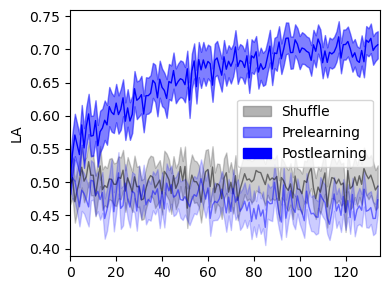

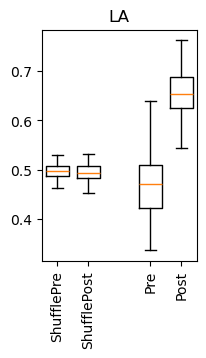

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
Condition 372.3710 3.0000 297.0000 0.0000

    Condition1   Condition2  T-Statistic       P-Value  Corrected P-Value
0         Post          Pre    21.715824  1.949372e-39       1.169623e-38
1         Post  ShufflePost    27.241869  8.573022e-48       5.143813e-47
2         Post   ShufflePre    27.214256  9.368083e-48       5.620850e-47
3          Pre  ShufflePost    -4.055991  9.965238e-05       5.979143e-04
4          Pre   ShufflePre    -4.439082  2.350522e-05       1.410313e-04
5  ShufflePost   ShufflePre    -1.158001  2.496496e-01       1.000000e+00


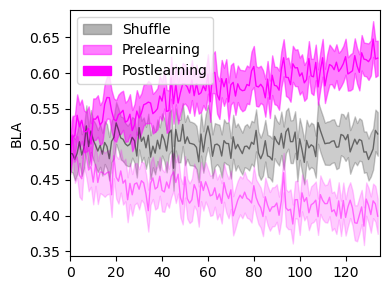

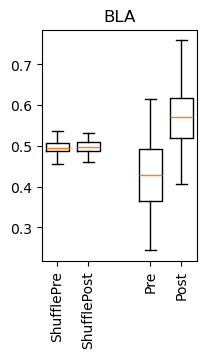

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
Condition 126.0524 3.0000 297.0000 0.0000

    Condition1   Condition2  T-Statistic       P-Value  Corrected P-Value
0         Post          Pre    15.939444  4.344125e-29       2.606475e-28
1         Post  ShufflePost    10.204820  3.911654e-17       2.346993e-16
2         Post   ShufflePre    10.140231  5.409709e-17       3.245825e-16
3          Pre  ShufflePost    -8.244468  7.166492e-13       4.299895e-12
4          Pre   ShufflePre    -8.672342  8.527477e-14       5.116486e-13
5  ShufflePost   ShufflePre     0.245805  8.063421e-01       1.000000e+00


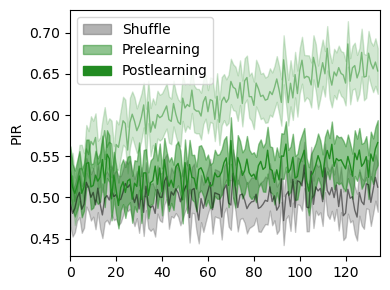

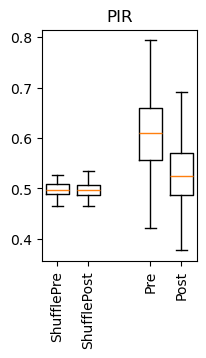

                  Anova
          F Value  Num DF  Den DF  Pr > F
-----------------------------------------
Condition 109.2783 3.0000 297.0000 0.0000

    Condition1   Condition2  T-Statistic       P-Value  Corrected P-Value
0         Post          Pre   -10.661332  3.967179e-18       2.380307e-17
1         Post  ShufflePost     3.869274  1.956473e-04       1.173884e-03
2         Post   ShufflePre     3.866300  1.977292e-04       1.186375e-03
3          Pre  ShufflePost    13.957490  4.023736e-25       2.414242e-24
4          Pre   ShufflePre    14.384657  5.399610e-26       3.239766e-25
5  ShufflePost   ShufflePre    -0.289585  7.727396e-01       1.000000e+00
                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  1.4159 3.0000 6.0000 0.3272



C:\Users\Cristina\anaconda3\Lib\site-packages\statsmodels\stats\anova.py:515: FutureWarning: The provided callable <function mean at 0x000002AF86063600> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(self.aggregate_func))


In [13]:
# Cell 2: Main analysis

from pathlib import Path

# Paths
cwd = Path.cwd()
basepath = cwd / "Figure4FG"
runname = "experiment1"
savename = "experiment1"
areas = ["LA", "BLA", "PIR"]
colors = ["blue", "magenta", "forestgreen"]

for a, area in enumerate(areas):
    accuracy = np.load(basepath / f"{runname}_accuracy_{area}.npy")
    shuffle = np.load(basepath / f"{runname}_accuracyshuffle_{area}.npy")

    # Extract pre/post learning accuracy
    accuracy_pre = np.mean(accuracy[:, :, :, 0], axis=2)
    accuracy_post = np.mean(accuracy[:, :, :, 1], axis=2)
    sem_pre = stats.sem(accuracy[:, :, :, 0], axis=2)
    sem_post = stats.sem(accuracy[:, :, :, 1], axis=2)

    shuffle_pre = np.mean(shuffle[:, :, :, 0], axis=2)
    shuffle_post = np.mean(shuffle[:, :, :, 1], axis=2)
    sem_shuffle_pre = stats.sem(shuffle[:, :, :, 0], axis=2)
    sem_shuffle_post = stats.sem(shuffle[:, :, :, 1], axis=2)

    # Parameters for window averaging
    starttime, stoptime = 55, 75

    minneuronnumber = 137 - 2
    #minneuronnumber = accuracy.shape[0] - 5
    #if area == "PIR":
        #minneuronnumber = 195

    # Mean accuracy across neurons for plotting
    meanaccuracypre = np.mean(accuracy_pre[2:2+minneuronnumber, starttime:stoptime], axis=1)
    meanaccuracy_post = np.mean(accuracy_post[2:2+minneuronnumber, starttime:stoptime], axis=1)
    meanaccuracysem_pre = np.mean(sem_pre[2:2+minneuronnumber, starttime:stoptime], axis=1)
    meanaccuracysem_post = np.mean(sem_post[2:2+minneuronnumber, starttime:stoptime], axis=1)

    shufflemeanaccuracypre = np.mean(shuffle_pre[2:2+minneuronnumber, starttime:stoptime], axis=1)
    shufflemeanaccuracy_post = np.mean(shuffle_post[2:2+minneuronnumber, starttime:stoptime], axis=1)
    shufflemeanaccuracysem_pre = np.mean(sem_shuffle_pre[2:2+minneuronnumber, starttime:stoptime], axis=1)
    shufflemeanaccuracysem_post = np.mean(sem_shuffle_post[2:2+minneuronnumber, starttime:stoptime], axis=1)

    allshufflemean = np.mean(np.vstack((shufflemeanaccuracypre, shufflemeanaccuracy_post)), axis=0)
    allshufflesem = np.mean(np.vstack((shufflemeanaccuracysem_pre, shufflemeanaccuracysem_post)), axis=0)

    # Plot decoding accuracy curves
    plt.close()
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(allshufflemean, color="black", alpha=0.5, lw=1)
    ax.fill_between(np.arange(minneuronnumber), allshufflemean - allshufflesem,
                    allshufflemean + allshufflesem, color="black", alpha=0.2)

    ax.plot(meanaccuracypre, color=colors[a], alpha=0.5, lw=1)
    ax.plot(meanaccuracy_post, color=colors[a], lw=1)
    ax.fill_between(np.arange(minneuronnumber), meanaccuracypre - meanaccuracysem_pre,
                    meanaccuracypre + meanaccuracysem_pre, color=colors[a], alpha=0.2)
    ax.fill_between(np.arange(minneuronnumber), meanaccuracy_post - meanaccuracysem_post,
                    meanaccuracy_post + meanaccuracysem_post, color=colors[a], alpha=0.5)

    ax.set_xlim([0, minneuronnumber])
    ax.set_ylabel(area)

    # Legend
    shuffle_patch = mpatches.Patch(color="dimgrey", alpha=0.5, label="Shuffle")
    pre_patch = mpatches.Patch(color=colors[a], alpha=0.5, label="Prelearning")
    post_patch = mpatches.Patch(color=colors[a], label="Postlearning")
    ax.legend(handles=[shuffle_patch, pre_patch, post_patch])

    plt.tight_layout()
    plt.show()
    fig.savefig(basepath / f"{area}{savename}_decodingaccuracy.png", format="png")

    # Quantification: area under curve
    shufflepre, meanshufflepre, semshufflepre = meansem_area(shuffle, starttime, stoptime, 0, minneuronnumber)
    shufflepost, meanshufflepost, semshufflepost = meansem_area(shuffle, starttime, stoptime, 1, minneuronnumber)
    pre, meanpre, sempre = meansem_area(accuracy, starttime, stoptime, 0, minneuronnumber)
    post, meanpost, sempost = meansem_area(accuracy, starttime, stoptime, 1, minneuronnumber)

    # Boxplot quantification
    plt.close()
    fig, ax = plt.subplots(figsize=(2, 3))
    ax.boxplot([shufflepre/minneuronnumber, shufflepost/minneuronnumber,
                pre/minneuronnumber, post/minneuronnumber],
               positions=[1, 2, 4, 5], showfliers=False, widths=0.75)
    ax.set_title(area)
    ax.set_xticks([1, 2, 4, 5])
    ax.set_xticklabels(("ShufflePre", "ShufflePost", "Pre", "Post"), rotation=90)

    plt.show()
    fig.savefig(basepath / f"{area}{savename}_quantification.png", format="png")

    # Run stats
    anova, df = calculatestats(shufflepre, shufflepost, pre, post)

    # Append to master dataframe
    if a == 0:
        dfall = pd.DataFrame({
            "AUC": np.concatenate([shufflepre, shufflepost, pre, post]),
            "Condition": (["ShufflePre"] * 100 + ["ShufflePost"] * 100 +
                          ["Pre"] * 100 + ["Post"] * 100),
            "Subject": [area] * 400,
            "Iteration": np.tile(np.arange(1, 101), 4)
        })
    else:
        dfall = pd.concat([dfall, pd.DataFrame({
            "AUC": np.concatenate([shufflepre, shufflepost, pre, post]),
            "Condition": (["ShufflePre"] * 100 + ["ShufflePost"] * 100 +
                          ["Pre"] * 100 + ["Post"] * 100),
            "Subject": [area] * 400,
            "Iteration": np.tile(np.arange(1, 101), 4)
        })], ignore_index=True)

# Group-level ANOVA
anova_results = AnovaRM(dfall, "AUC", "Subject", within=["Condition"], aggregate_func=np.mean).fit()
print(anova_results)
